# Tarea 2: Random forest

### 1) Procesamiento de datos

In [1]:
from collections import defaultdict
import math
import pandas as pd
import numpy as np
import random
import seaborn as sn
import matplotlib.pyplot as plt

In [2]:
def split_frame(frame):
    
    """ Función que divide el dataset en set de entrenamiento y testeo"""
    
    num = int(len(frame)*0.8)
    training_set = frame.iloc[0:num]
    test_set = frame.iloc[num::]
    return training_set, test_set

### 2) Implementación Árbol

Para splitear correctamente en cada nivel del arbol, lo que haré será elegir un número random de features y un porcentaje arbitrario del total de valores diferentes que pueda tener esta feature, calcular la ganancia de cada uno y quedarme con la mejor de las mejores, esto debido a que hacerlo con todas las features y todos los valores sería muy caro en terminos de tiempo, y puede que no afecte en gran medida los arboles construidos

In [3]:
def get_sum(valor, largo):
    prob = valor/largo 
    return (prob)*(math.log2(prob)) ##fucion matematica de entropía

In [4]:
def calculate_entropy(df, feature):
    columna = df[feature] #la columna de clasificacion
    total = len(columna) #el largo de la base de datos
    valores = columna.value_counts() #los valores diferentes que tiene y sus contadores
    suma = sum(valores.apply(get_sum, args = [total])) #suma de la entropia
    return suma*-1

In [6]:
def calculate_best_value(value, feature, entropia, dataset, target):
    
    """ Funciónn que calcula la ganancia de información spliteando en 2 deacuerdo al valor value"""
    
    largo = len(dataset)
    #split
    izquierda = dataset[dataset[feature]< value]
    derecha = dataset[dataset[feature]>= value]
    
    #si uno de los 2 lados tiene largo 0, no estoy dividiendo nada, por lo que la ganancia es 0
    if len(izquierda) == 0 or len(derecha)== 0:
        return 0
    
    entropia_derecha = calculate_entropy(derecha, target)
    entropia_izquierda = calculate_entropy(izquierda, target)
    
    sumatoria = ((len(derecha)/largo)* entropia_derecha) +((len(izquierda)/largo)*entropia_izquierda )

    return entropia-sumatoria

In [21]:
def func_features(feature, dataset, entropia):
    
    """Función que para cada feature saca los valores únicos y de ellos elige un porcentaje random para 
    calcular la gaanancia de cada uno de estos valores y elegir el mejor """
    
    val = list(dataset[feature[0]].unique())
    largo = len(val)
    
    #elijo random
    if largo> 60:
        valores = pd.Series(random.sample(val, int(0.035*largo)))
    elif largo>12 and largo<=60:
        valores = pd.Series(random.sample(val, int(0.5*largo)))
    else:
        valores = pd.Series(val)
    
    #por cada valor, calculo su ganancia
    ganancias = valores.apply(calculate_best_value, args=(feature[0], entropia, dataset, "Class",))
    #elijo la maxima
    max_gain = ganancias.idxmax()
    
    valor_max_gain = valores[max_gain]
    
    #retorno la feature, value, y ganancia
    return pd.Series([feature[0], max_gain, valor_max_gain])

In [22]:
class Node():
    
    ide = 0
    
    def __init__(self, df, value=None, father=None, category=None):
        self.df = df
        #category será el nombre del nodo(atributo)
        self.category = category
        #value será los posibles valores de mi padre
        self.value = value
        self.father = father
        self.left = None
        self.right = None
        self. id = Node.ide
        Node.ide += 1
    
    
    def select_feature(self):
        """
        Este metodo calcula la entropia de la base de datos y retorna la feature que
        mejor separa los registos de las distintas claseldses
        """
        feat = list(self.df.columns.values) # saco todos los atributos
        
        feat.remove("Class")
        features = random.sample(feat, int(0.35*len(feat)))
                                 
        entropia = calculate_entropy(self.df, "Class") #entropia de la clase a clasificar
        #para luego elegir el mejor de ellos.
        data = pd.DataFrame(data = {"feature": features})
        
        #para los valores random de las features retorno los split que me den la mejor ganancia
        new_data = data.apply(func_features, axis=1, args= (self.df, entropia))
        new_data.columns = ["feature", "gain", "value"]
        
        #elijo el que me da la ganancia maxima
        best_gain, index_gain = new_data["gain"].max(), new_data["gain"].idxmax()
        
        if best_gain>0:
            value = new_data.loc[index_gain]["value"]
            feat = new_data.loc[index_gain]["feature"]
            return (feat, value)
        
        else: return ""
    
    
    def split_data_base(self, feature, value):
        """
        Este metodo recibe una feature y divide la base de datos en base a ella 
        generando los hijos del nodo.
        """
        self.category= feature
        self.value = value #mi valor de comparación para menor o mayoroigual
        
        #saco los hijos que salen del split 
        
        izquierda = self.df[self.df[feature]< value]
        nodo_izq = Node(izquierda, father = self)
        
        derecha = self.df[self.df[feature]>= value]
        nodo_der = Node(derecha, father = self)
        # y los agrego
        self.left = nodo_izq
        self.right = nodo_der
        
        return None 

#### Entrenamiento y predicción de un arbol

In [24]:
def fit_arbol(nodo, min_data, max_deep):
    """
    Crear recursivamente el arbol con los datos. El algoritmo debe parar cuando se llega a una altura máxima
    o cuando queda un mínimo de datos en el set de datos de cada nodo. 
    
    Debe retonar el primer nodo del árbol completado
    """
 
    if (max_deep == 0) or  (len(nodo.df["Class"].unique()) ==1) or (len(nodo.df) <= min_data) :
        #si es una hoja el nodo, entonces le asigno una clasificacion en categoria
        clasificacion = nodo.df["Class"].value_counts().idxmax()
        nodo.category = clasificacion
        return None
    
    #selecciono la feature
    feature = nodo.select_feature()
    
    if feature == "":
        #si la entropía retorno " ", osea que es 0, le doy la clasificacion del que mas se repite
        clasificacion = nodo.df["Class"].value_counts().idxmax()
        nodo.category = clasificacion
        return None
    
    #spliteo y creo los nodos hijos
    nodo.split_data_base(feature[0], feature[1])
    
    fit_arbol(nodo.left, min_data, max_deep-1)
    fit_arbol(nodo.right, min_data, max_deep-1)
  
    return None 


def predict_arbol(tree, data_to_predict):
    """
    Predice el valor de un dato nuevo (data_to_predict)
    """
    #recibe una fila del dataframe
    
    # si no tiene hijos => es una hoja y category es la clasificación  
    if (tree.left==None and tree.right==None):
        return tree.category
    
    # si tiene busco en el tree mas abajo.
    hijo = tree.left if data_to_predict[tree.category]< tree.value else tree.right
    
    if not hijo: #probar si funciona sin esta linea
        return tree.df["Class"].value_counts().idxmax()
    
    return predict_arbol(hijo, data_to_predict)

### 3) Implementación Forest

In [39]:
class Forest:
    def __init__(self):
        self.arboles = []
    
    def fit(self, data, target, n_arboles = None, min_data= None, max_deep=None):
        # Si no se da, se deja por default
        if not n_arboles:
            n_arboles = 55
        if not min_data:
            min_data = 40
        if not max_deep:
            max_deep = 10
        
        #elijo el largo de cada sub dataset
        samples = int(len(data)/n_arboles) + 5
        
        #hago n_arboles números de dataset diferentes con filas random del dataset total
        subdatasets = [data.sample(samples) for i in range(n_arboles)]
        #creo los n arboles
        self.arboles = [Node(subdatasets[i]) for i in range(n_arboles)]
        
        cont = 0
        for arbol in self.arboles:
            #se fitea cada arbol
            fit_arbol(arbol, min_data, max_deep)
            print(cont)
            cont +=1
            
        print("fin")
        return None
    
    def predict(self, dataset):
        #predigo con los n arboles y elijo el maximo
        predicciones = pd.Series([predict_arbol(arbol, dataset) for arbol in self.arboles])
        return predicciones.value_counts().idxmax()
       

### Ejecución del algoritmo

Se demora aproximadamente 1 hora y 20 min uwu

In [40]:
frame = pd.read_csv("FATS_GAIA.dat")
training_set, test_set = split_frame(frame)

In [41]:
forest = Forest()
forest.fit(training_set, "Class", 80, 30, 11)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
fin


In [42]:
contador = 0
resultados = []
for index, row in test_set.iterrows():
    obtenido = forest.predict(row)
    resultados.append(obtenido)
    if row["Class"] == obtenido:
        contador += 1
print(f"Acertado {contador/len(test_set)}")

Acertado 0.6559276423979669


Acá podemos ver que nuestro forest tiene un grado de aciertos del 65% aproximadamente, lo cual si bien, es mayor que la mitad, aún es bajo, este podría mejorar aumentando la cantidad de arboles, o ajustando la profundidad de cada uno de estos.

### 4) Visualización de efectividad

In [43]:
predicted = pd.Series(resultados, name="Predicted")
rial = test_set["Class"].reset_index(drop = True)

In [44]:
df_confusion = pd.crosstab(rial, predicted)
l = list(set(list(df_confusion.index)+ list(df_confusion.columns)))
df_confusion

Predicted,MIRA_SR,RRAB,RRC
Class,,,
ACEP,98,72,2
ARRD,13,58,5
CEP,1626,651,24
DSCT_SXPHE,2766,754,459
MIRA_SR,4421,30,0
RRAB,1168,14332,403
RRC,892,3295,7572
RRD,33,302,78
T2CEP,1015,65,0


In [45]:
df_cm = pd.DataFrame(df_confusion, index = [i for i in l],
                  columns = [i for i in l])
df_cm.fillna(0, inplace=True)
df_cm

,CEP,MIRA_SR,RRD,T2CEP,ACEP,RRC,ARRD,DSCT_SXPHE,RRAB
CEP,0.0,1626,0.0,0.0,0.0,24,0.0,0.0,651
MIRA_SR,0.0,4421,0.0,0.0,0.0,0,0.0,0.0,30
RRD,0.0,33,0.0,0.0,0.0,78,0.0,0.0,302
T2CEP,0.0,1015,0.0,0.0,0.0,0,0.0,0.0,65
ACEP,0.0,98,0.0,0.0,0.0,2,0.0,0.0,72
RRC,0.0,892,0.0,0.0,0.0,7572,0.0,0.0,3295
ARRD,0.0,13,0.0,0.0,0.0,5,0.0,0.0,58
DSCT_SXPHE,0.0,2766,0.0,0.0,0.0,459,0.0,0.0,754
RRAB,0.0,1168,0.0,0.0,0.0,403,0.0,0.0,14332


Acá visualizamos una matriz de confusión, la cual nos permite ver entre que clases nuestro algoritmo se está "confundiendo", análicemos:

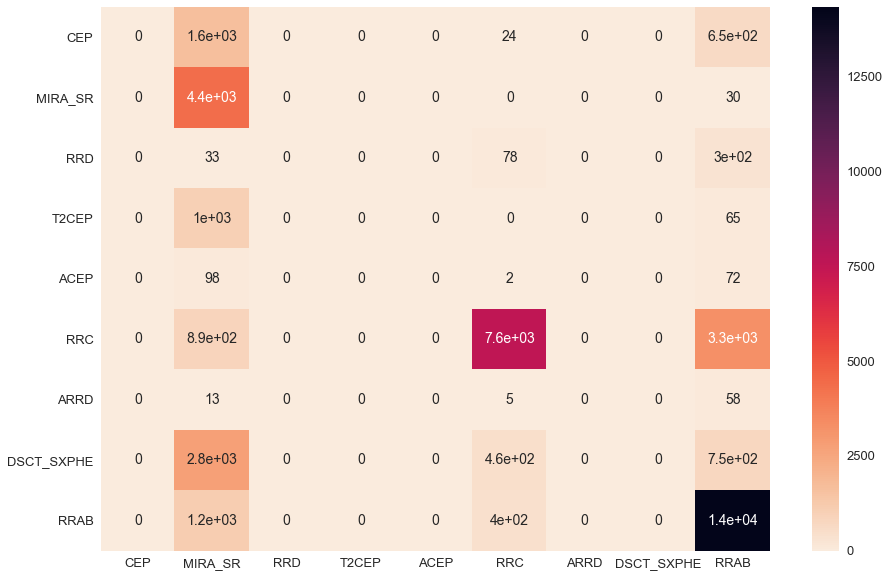

In [46]:
plt.figure(figsize = (15,10))
sn.set(font_scale=1.3)#for label size

sn.heatmap(df_cm, annot=True,annot_kws={"size": 14}, cmap = sn.cm.rocket_r)# font size

plt.show()

Como vemos en la matriz el algoritmo esta confundiendo las clases  RRAB con MIRA_SR, RRC con RRAB, en particular, MIRA_SR y RRAB se confunde con varias otras, esto podría ser debido a que ambas tengan los valores de las features elegidas parecidos, además, como no se están comparando todas las features ya que eran bastantes, puede que justo las que se hayan elegido, hayan sido las que tenían en común estas clases.

### 5) Visualización De un Árbol

In [47]:
from graphviz import Graph, Digraph

In [48]:
def create_visualization(raiz, graph):
    if not raiz:
        return None
    
    if raiz.left:
        if raiz.left.left or raiz.left.right:
            graph.edge(f"{raiz.category} \n < {raiz.value} \n id {raiz.id}", f"{raiz.left.category} \n < {raiz.left.value} \n id {raiz.left.id}")
        else:
            graph.edge(f"{raiz.category} \n < {raiz.value} \n id {raiz.id}", f"{raiz.left.category} \n id {raiz.left.id}")
    
            
    if raiz.right:
        if raiz.right.left or raiz.right.right:
            graph.edge(f"{raiz.category} \n < {raiz.value} \n id {raiz.id}", f"{raiz.right.category} \n < {raiz.right.value} \n id {raiz.right.id}")
        else:
            graph.edge(f"{raiz.category} \n < {raiz.value} \n id {raiz.id}", f"{raiz.right.category} \n id {raiz.right.id}")
        
    create_visualization(raiz.left, graph)
    create_visualization(raiz.right, graph)


In [49]:
h = Digraph('hello')

La siguiente visualización consiste en un árbol que contiene un nodo, con el nombre del atributo de separación, el valor y la id correspondiente a ese nodo, el hijo izquierdo corresponde al nodo con feature < valor del nodo y el derecho al nodo con feature >= al valor del nodo

In [50]:
create_visualization(forest.arboles[0], h)

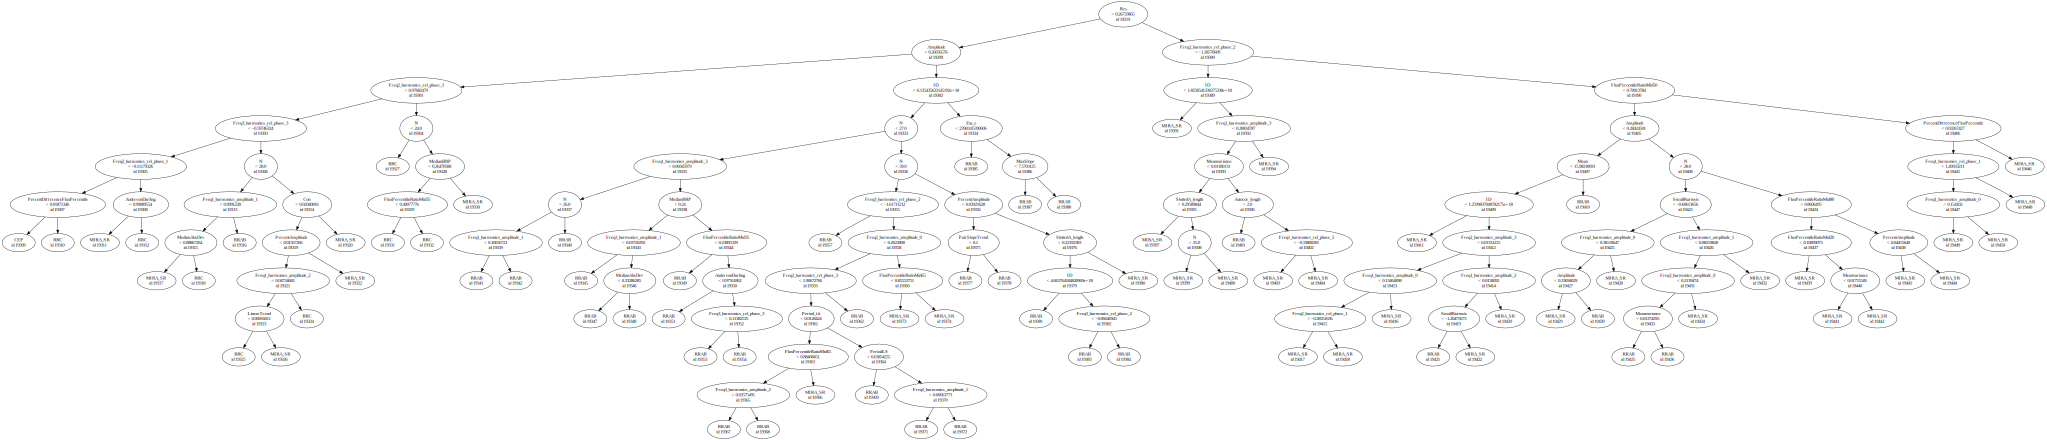

In [51]:
h

### 6) Análisis de resultados

Ya se ha analisado algunos de los resultados obtenidos como por ejemplo la efectividad de las predicciones y como se podrían mejorar, obtuve estos resultados comparando lo obtenido versus lo real en el set de testeo, realizando luego una matriz de confusión e identificando las clases confundidas.

Como vemos en este algoritmos hay muchos parametros que pueden variar, como por ejemplo la cantidad de arboles y los niveles de profundidad.
Si estos son cambiados se pueden ver tanto mejoras en el algoritmo como todo lo contrario, por ejemplo, si el número de arboles es muy grande, la data entrante se spliteará cada vez en partes más pequeñas, por lo que los arboles dentro del forest no serán tan efectivos, si las profundidades son muy grandes se podría apreciar un overfitting lo que haría que finalmente el algoritmo empeorara con datos nuevos entrantes.
Lo ideal para la profundidad, es que cuando la ganancia de información comience a disminuir respecto a las ganancias anteriores, el arbol debería parar de crecer, para el número de arboles, con exactitud, no lo sé, este debe depender de la cantidad de datos en el set de entrenamiento, si son muchos, vale la pena hacer varios(muchos) arboles, mientras que si son pocos, basta con pocos arboles.